# Tutorial 03: Customise acquisition function
We will see how to customise various acquisition functions for the SOBER algorithm.<br>
Basically, we can use a nice functions of BoTorch.

We will consider the following domain types (click link to skip):
- Basic acquisition functions: EI and UCB <a href="#section1">link</a>
- Information-theoretic acquisition functions <a href="#section2">link</a>

If you want to try out the fully Bayesian Gaussian process (FBGP) based acquisition functions, see tutorial 04.

## 0. import libraries

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from SOBER._utils import TensorManager
tm = TensorManager()
warnings.filterwarnings('ignore')

<a id ="section1"></a>
## 1. Basic acquisition functions: EI and UCB
Let's get started with the toy example of 6-dimensional Hartmann function.<br>
- number of dimensions: 6
- bounds: 0 from 1
- variable type: continuous
- ground truth: 3.32237
- optimisation: maximisation

We prepared the **setup** function for each task.<br>
We can call prior and testfunction with just one line of code.

In [2]:
from experiments._hartmann import setup_hartmann
prior, TestFunction = setup_hartmann()

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### 1.1 Define the acquisition function
We will define the acquisition function using a BoTorch library. <br>

In [3]:
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model

def set_rbf_model(X, Y):
    """
    Set up the Gaussian process model with RBF kernel.
    
    Args:
    - X: torch.tensor, the observed input X
    - Y: torch.tensor, the observed outcome Y
    
    Return:
    - model: gpytorch.models, function of GP model.
    """
    base_kernel = RBFKernel()
    covar_module = ScaleKernel(base_kernel)

    # Fit a GP model
    train_Y = (Y - Y.mean()) / Y.std()
    train_Y = train_Y.view(-1).unsqueeze(1)
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X, train_Y, likelihood=likelihood, covar_module=covar_module)
    if tm.is_cuda():
        return model.cuda()
    else:
        return model

def optimise_model(model):
    """
    Optimise the hyperparameters of Gaussian process model using L-BFGS-B (BoTorch optimizer)
    
    Args:
    - model: gpytorch.models, the optimised GP model.
    
    Return:
    - model: gpytorch.models, the optimised GP model.
    """
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

BoTorch is great but it is dedicated for sample average approximation (SAA), which requires additional dimension for input. <br>
We need to create a wrapper of BoTorch acquisition function module for SOBER.<br>
But no worries, it's super easy!

In [4]:
# setup the acquisition functions
from botorch.acquisition.analytic import ExpectedImprovement, UpperConfidenceBound

class AcquisitionFunction:
    def __init__(self, model, label="EI"):
        self.label = label
        self.update_model(model)
        
    def update_model(self, model):
        if self.label == "EI":
            best_f = model.train_targets.max().item()
            self.af = ExpectedImprovement(model, best_f=best_f)
        elif self.label == "UCB":
            self.af = UpperConfidenceBound(model, beta=0.2)
        else:
            raise ValueError("The label should be either EI or UCB")
    
    def __call__(self, x):
        return self.af(x.unsqueeze(1)).detach()

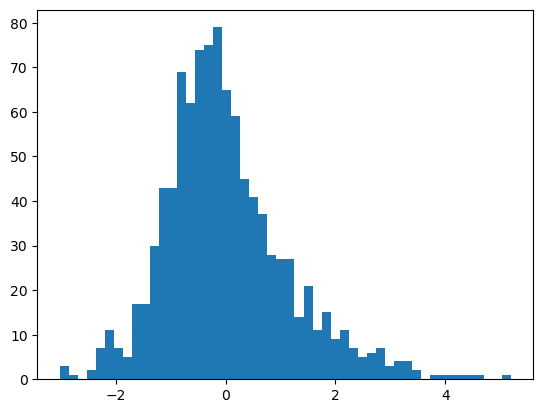

In [5]:
# initial sampling
n_init = 100
Xall = prior.sample(n_init)
Yall = TestFunction(Xall)
model = set_rbf_model(Xall, Yall)

AF = AcquisitionFunction(model, label="UCB")
Xtest = prior.sample(1000)
af = AF(Xtest)
plt.hist(tm.numpy(af), 50)
plt.show()

## 1.2 run SOBER
That's all! We pass this function to SOBER, then kernel recombination algorithm tries to find the quadrature samples that have the largest total acquisition function values.

In [6]:
from SOBER._sober import Sober

def run_SOBER(
    seed,
    batch_size,        # number of batch samples
    n_rec,             # number of candidates sampled from pi
    n_nys,             # number of samples for Nyström approximation
    n_init,            # number of initial samples
    n_iterations,      # number of iterations (batches)
    label="EI",        # acquisition function
):
    torch.manual_seed(seed)  # random seed

    # initial sampling
    Xall = prior.sample(n_init)
    Yall = TestFunction(Xall)
    model = set_rbf_model(Xall, Yall)
    sober = Sober(prior, model)
    AF = AcquisitionFunction(model, label=label)
    
    results = []
    for n_iter in range(n_iterations):
        start = time.monotonic()
        model = set_rbf_model(Xall, Yall)   # GP model with RBF kernel
        model = optimise_model(model)       # Optimise hyperparameters
        sober.update_model(model)           # pass the updated model to sober
        AF.update_model(model)              # update model for acquisition function
        X_batch = sober.next_batch(
            n_rec,
            n_nys,
            batch_size,
            calc_obj=AF,
            verbose=False,
        )
        end = time.monotonic()
        interval = end - start

        Y_batch = TestFunction(X_batch)
        Xall = torch.cat((Xall, X_batch), dim=0)
        Yall = torch.cat((Yall, Y_batch), dim=0)

        print(f"{len(Xall)}) Best value: {Yall.max().item():.5e}")
        print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
        results.append([interval, Yall.max().item()])
    return torch.tensor(results)

def visualise_results(results, ax, label, color):
    idx_batch = torch.arange(n_iterations)

    ax[0].plot(idx_batch, results[:,1], 'bo-', label=label, color=color)
    ax[0].legend()
    ax[0].set_xlabel("number of batches")
    ax[0].set_ylabel("y")

    ax[1].plot(idx_batch, results[:,0], 'bo-', label=label, color=color)
    ax[1].set_xlabel("number of batches")
    ax[1].set_ylabel("overhead [s]")
    ax[1].legend()

110) Best value: 3.08814e+00
Acquisition time [s]: 9.26049e+00, per sample [ms]: 9.26049e+02
120) Best value: 3.14539e+00
Acquisition time [s]: 1.63637e+01, per sample [ms]: 1.63637e+03
130) Best value: 3.14539e+00
Acquisition time [s]: 2.20691e+01, per sample [ms]: 2.20691e+03
140) Best value: 3.14539e+00
Acquisition time [s]: 2.19264e+01, per sample [ms]: 2.19264e+03
150) Best value: 3.14539e+00
Acquisition time [s]: 2.48422e+01, per sample [ms]: 2.48422e+03
110) Best value: 3.01650e+00
Acquisition time [s]: 7.65308e+00, per sample [ms]: 7.65308e+02
120) Best value: 3.01650e+00
Acquisition time [s]: 1.70039e+01, per sample [ms]: 1.70039e+03
130) Best value: 3.05334e+00
Acquisition time [s]: 2.44974e+01, per sample [ms]: 2.44974e+03
140) Best value: 3.14481e+00
Acquisition time [s]: 2.94842e+01, per sample [ms]: 2.94842e+03
150) Best value: 3.15412e+00
Acquisition time [s]: 2.82272e+01, per sample [ms]: 2.82272e+03


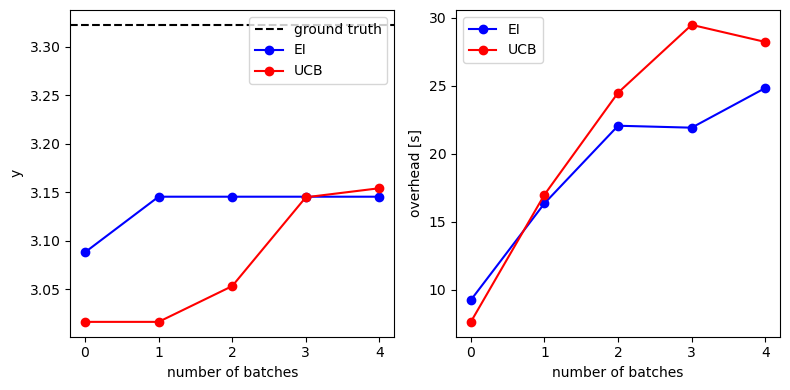

In [7]:
seed = 0           # random seed
batch_size = 10    # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8,4))
colors = ["b", "r"]
ax[0].axhline(y=3.32237, linestyle="--", color="k", label="ground truth")

for idx, af in enumerate(["EI", "UCB"]):
    results = run_SOBER(
        seed,
        batch_size,        # number of batch samples
        n_rec,             # number of candidates sampled from pi
        n_nys,             # number of samples for Nyström approximation
        n_init,            # number of initial samples
        n_iterations,      # number of iterations (batches)
        label=af,          # acquisition function
    )

    visualise_results(results, ax, af, colors[idx])
    
plt.show()

In this case, UCB was slightly better.<br>
Note that SOBER works finely without an acquisition function.

<a id ="section2"></a>
## 2. Information-theoretic acquisition functions: MES
We provide the example how to use information-theoretic acquisition function. For speed, we recommend max-value entropy search (MES), particularly GIBBON approximation. However, you can use arbitrary acquisition functions.<br>
For more various examples, see [BoTorch tutorials](https://botorch.org/tutorials/information_theoretic_acquisition_functions)

### 1.1 Define the MES acquisition function
We will define the acquisition function using a BoTorch library. <br>

In [8]:
# setup the acquisition functions
from botorch.acquisition.max_value_entropy_search import qLowerBoundMaxValueEntropy
class AcquisitionFunction:
    def __init__(self, model, label="MES"):
        self.label = label
        self.update_model(model, X_cand=None)
        
    def update_model(self, model, X_cand=None):
        if self.label == "EI":
            best_f = model.train_targets.max().item()
            self.af = ExpectedImprovement(model, best_f=best_f)
        elif self.label == "UCB":
            self.af = UpperConfidenceBound(model, beta=0.2)
        elif self.label == "MES":
            if not X_cand == None:
                self.af = qLowerBoundMaxValueEntropy(model, X_cand)
        else:
            raise ValueError("The label should be either EI, UCB, or MES")
        
    def __call__(self, x):
        return self.af(x.unsqueeze(1)).detach()

In [9]:
# initial sampling
n_init = 100
Xall = prior.sample(n_init)
Yall = TestFunction(Xall)
model = set_rbf_model(Xall, Yall)

X_cand = prior.sample(20000)
AF = AcquisitionFunction(model, label="MES")
AF.update_model(model, X_cand)
Xtest = prior.sample(1000)
start = time.monotonic()
AF(Xtest)
end = time.monotonic()
wall_time = (end - start) / len(Xtest) * 1e6
print(f"Acquisition time per sample [μs]: {wall_time:.5e}")

Acquisition time per sample [μs]: 6.94796e+01


## 1.2 run SOBER
That's all! We pass this function to SOBER, then kernel recombination algorithm tries to find the quadrature samples that have the largest total acquisition function values.

In [10]:
from SOBER._sober import Sober

def run_SOBER(
    seed,
    batch_size,        # number of batch samples
    n_rec,             # number of candidates sampled from pi
    n_nys,             # number of samples for Nyström approximation
    n_init,            # number of initial samples
    n_iterations,      # number of iterations (batches)
    label="EI",        # acquisition function
):
    torch.manual_seed(seed)  # random seed

    # initial sampling
    Xall = prior.sample(n_init)
    Yall = TestFunction(Xall)
    model = set_rbf_model(Xall, Yall)
    sober = Sober(prior, model)
    AF = AcquisitionFunction(model, label=label)
    
    results = []
    for n_iter in range(n_iterations):
        start = time.monotonic()
        model = set_rbf_model(Xall, Yall)   # GP model with RBF kernel
        model = optimise_model(model)       # Optimise hyperparameters
        sober.update_model(model)           # pass the updated model to sober
        if label == "MES":
            X_cand, _ = sober.sampling(n_rec)   # sampling from pi
            AF.update_model(model, X_cand)
        else:
            AF.update_model(model)              # update model for acquisition function
        X_batch = sober.next_batch(
            n_rec,
            n_nys,
            batch_size,
            calc_obj=AF,
            verbose=False,
        )
        end = time.monotonic()
        interval = end - start

        Y_batch = TestFunction(X_batch)
        Xall = torch.cat((Xall, X_batch), dim=0)
        Yall = torch.cat((Yall, Y_batch), dim=0)

        print(f"{len(Xall)}) Best value: {Yall.max().item():.5e}")
        print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
        results.append([interval, Yall.max().item()])
    return torch.tensor(results)

def visualise_results(results, ax, label, color):
    idx_batch = torch.arange(n_iterations)

    ax[0].plot(idx_batch, results[:,1], 'bo-', label=label, color=color)
    ax[0].legend()
    ax[0].set_xlabel("number of batches")
    ax[0].set_ylabel("y")

    ax[1].plot(idx_batch, results[:,0], 'bo-', label=label, color=color)
    ax[1].set_xlabel("number of batches")
    ax[1].set_ylabel("overhead [s]")
    ax[1].legend()

110) Best value: 3.08814e+00
Acquisition time [s]: 1.44343e+01, per sample [ms]: 1.44343e+03
120) Best value: 3.14539e+00
Acquisition time [s]: 2.79563e+01, per sample [ms]: 2.79563e+03
130) Best value: 3.14539e+00
Acquisition time [s]: 3.29609e+01, per sample [ms]: 3.29609e+03
140) Best value: 3.14539e+00
Acquisition time [s]: 3.05949e+01, per sample [ms]: 3.05949e+03
150) Best value: 3.14539e+00
Acquisition time [s]: 4.04120e+01, per sample [ms]: 4.04120e+03
110) Best value: 3.01650e+00
Acquisition time [s]: 1.35421e+01, per sample [ms]: 1.35421e+03
120) Best value: 3.01650e+00
Acquisition time [s]: 2.69859e+01, per sample [ms]: 2.69859e+03
130) Best value: 3.05334e+00
Acquisition time [s]: 3.33994e+01, per sample [ms]: 3.33994e+03
140) Best value: 3.14481e+00
Acquisition time [s]: 6.15222e+01, per sample [ms]: 6.15222e+03
150) Best value: 3.15412e+00
Acquisition time [s]: 3.50785e+01, per sample [ms]: 3.50785e+03
110) Best value: 2.89987e+00
Acquisition time [s]: 1.71654e+01, per sa

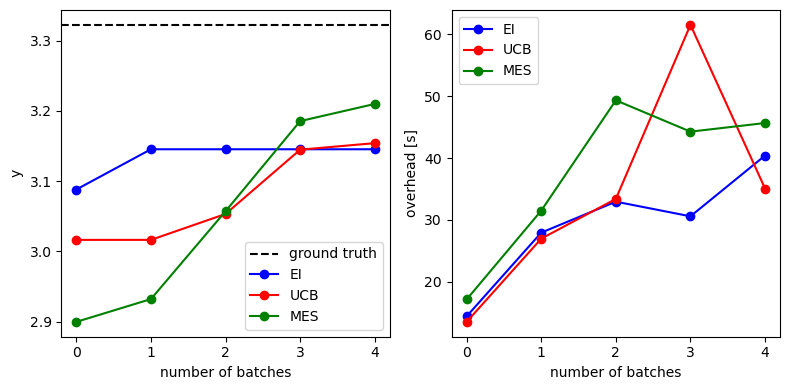

In [11]:
seed = 0           # random seed
batch_size = 10    # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8,4))
colors = ["b", "r", "g"]
ax[0].axhline(y=3.32237, linestyle="--", color="k", label="ground truth")

for idx, af in enumerate(["EI", "UCB", "MES"]):
    results = run_SOBER(
        seed,
        batch_size,        # number of batch samples
        n_rec,             # number of candidates sampled from pi
        n_nys,             # number of samples for Nyström approximation
        n_init,            # number of initial samples
        n_iterations,      # number of iterations (batches)
        label=af,          # acquisition function
    )

    visualise_results(results, ax, af, colors[idx])
    
plt.show()

In general, information-theoretic acquisition function performs better in a long run.